https://hrl.boyuai.com/chapter/1/%E5%A4%9A%E8%87%82%E8%80%81%E8%99%8E%E6%9C%BA

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class BernoulliBandit():
    """伯努利多臂老虎机，K表示拉杆个数"""
    def __init__(self,K) -> None:
        self.probs = np.random.uniform(size=K) # 随机生成K个0~1的数，作为拉动每根拉杆的获奖概率
        self.best_idx = np.argmax(self.probs) # 获取概率最大的拉杆
        self.best_prop = self.probs[self.best_idx] # 获取最大的获奖概率
        self.K = K
    
    def step(self, k) -> bool:
        # 玩家选择k号拉杆后，根据相应拉杆的获奖概率返回是否获奖
        if np.random.rand()<self.probs[k]:
            return True
        return False


In [4]:
np.random.seed(1) # 设定随机种子，使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号，其获奖的概率为%.4f" % (bandit_10_arm.best_idx,bandit_10_arm.best_prop))

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号，其获奖的概率为0.7203


In [5]:
class Solver():
    """多臂老虎机的算法基本框架"""
    def __init__(self, bandit:BernoulliBandit) -> None:
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)   #每根拉杆的尝试次数
        self.regret = 0.                        #当前步的懊悔
        self.actions = []       #记录每一步的动作
        self.regrets = []       # 记录每一步的累计懊悔

    def update_regret(self,k):
        # 计算累计懊悔并保存，k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prop - self.bandit.probs[k] 
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆，由具体的策略实现
        raise NotImplementedError
    def run(self, num_steps):
        # 运行一定次数，num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

In [6]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

In [7]:
class EpsilonGreedy(Solver):
    """epsilon贪婪算法"""
    def __init__(self, bandit: BernoulliBandit,epsilon:float = 0.01, init_prob:float = 1.0) -> None:
        super().__init__(bandit)
        self.epsilon = epsilon
        # 初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self) -> float:
        if np.random.random() < self.epsilon:
            k = np.random.randint(1,self.bandit.K) # 随机选择一根拉杆
        else:
            k = np.argmax(self.estimates) # 获取期望奖励估值最大的拉杆
        r = self.bandit.step(k)         #获取本次动作的奖励

        self.estimates[k] += 1./(self.counts[k]+1) * (r-self.estimates[k])
        return k

epsilon-贪婪算法的累积懊悔为： 215.9177427220631


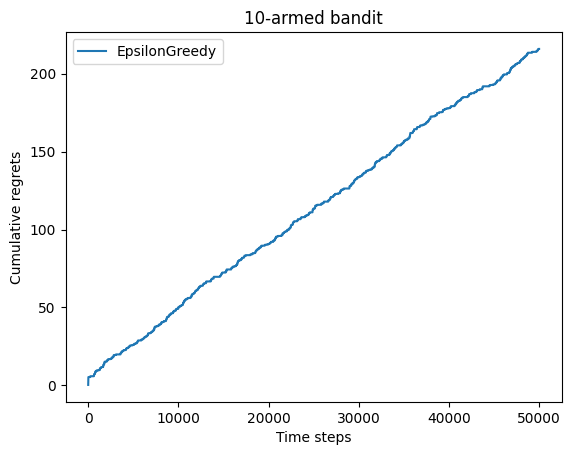

In [15]:
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(50000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

In [16]:
class DecayingEpsilonGreedy(Solver):
    """epsilon 值随时间衰减的epsilon-贪婪算法"""
    def __init__(self, bandit: BernoulliBandit, init_prob=1.0) -> None:
        super().__init__(bandit)
        self.estimates = np.array([init_prob]*self.bandit.K)
        self.total_count = 0
    def run_one_step(self):
        self.total_count+=1
        if np.random.random()<1/self.total_count:
            k = np.random.randint(0,self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        
        r = self.bandit.step(k)
        self.estimates[k] += 1./(self.counts[k]+1)*(r-self.estimates[k])
        return k    

epsilon值衰减的贪婪算法的累积懊悔为： 12.422395926525834


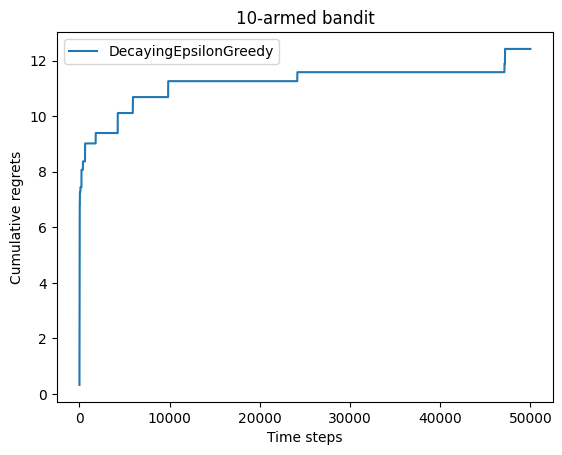

In [18]:
np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(50000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

In [22]:
class UCB(Solver):
    """UCB(upper confidence bound,上置信界)"""
    def __init__(self, bandit: BernoulliBandit,coef, init_prob=1.0) -> None:
        super().__init__(bandit)
        self.total_count = 0
        self.estimates= np.array([init_prob]*self.bandit.K)
        self.coef = coef
    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef *np.sqrt(np.log(self.total_count)/(2*(self.counts+1))) #计算上置信界
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] +=1.0/(self.counts[k]+1) * (r-self.estimates[k])
        return k

上置信界算法的累积懊悔为： 102.36369160442034


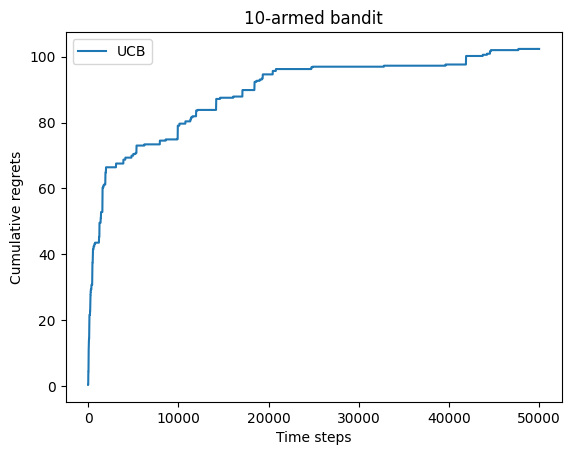

In [24]:
np.random.seed(1)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(50000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

In [29]:
class ThompsonSampling(Solver):
    """汤姆森采样"""
    def __init__(self, bandit: BernoulliBandit) -> None:
        super().__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a,self._b) # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)
        r= self.bandit.step(k)
        self._a[k] += r     #更新Beta分布的第一个参数
        self._b[k] += (1-r)     #更新Beta分布的第二个参数
        return k

汤普森采样算法的累积懊悔为： 76.65624910668318


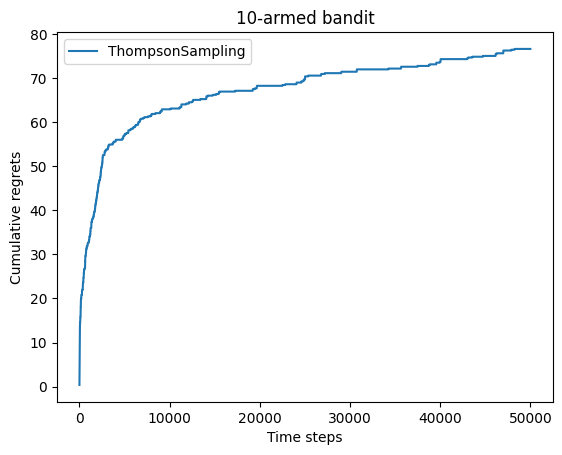

In [28]:
np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(50000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])